## Packages to be installed  

In [1]:
%pip install tensorflow
%pip install seaborn
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install opencv-python-headless
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import sys
import cv2
from skimage.metrics import structural_similarity as ssim
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import glob
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Concatenate, ZeroPadding2D, Dropout, ReLU
from tensorflow.keras.models import Model
import numpy as np
import time
from tqdm import tqdm 

2024-08-19 10:31:43.391455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 10:31:44.220422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 10:31:44.465273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 10:31:46.282203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 10:31:50.556256: W tensorflow/comp

## Load Data


In [5]:
# Define the root directory containing the dataset
root_dir = 'CT_MRI/Dataset Split/images'

# Function to load images from a directory
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
            labels.append(label)
    return images, labels

# Load images from trainA, trainB, testA, and testB directories
def load_dataset(root_dir):
    dataset = {'image': [], 'label': []}
    for subdir in ['trainA', 'trainB', 'testA', 'testB']:
        folder = os.path.join(root_dir, subdir)
        images, labels = load_images_from_folder(folder, subdir)
        dataset['image'].extend(images)
        dataset['label'].extend(labels)
    return pd.DataFrame(dataset)

# Load the dataset
df_images = load_dataset(root_dir)

# Print out basic information about the dataset
print(df_images.head())
print(f"Total images loaded: {len(df_images)}")

                                               image   label
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
Total images loaded: 1500


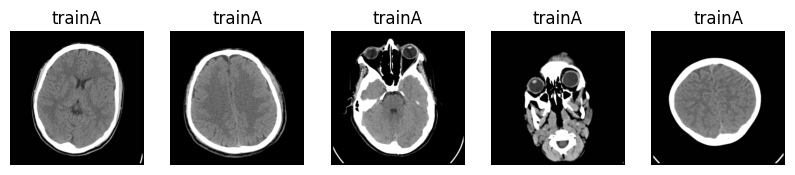

In [6]:
# Display a few sample images
plt.figure(figsize=(10, 5))
for i in range(min(5, len(df_images))):
    plt.subplot(1, 5, i+1)
    plt.imshow(df_images['image'].iloc[i], cmap='gray')
    plt.title(df_images['label'].iloc[i])
    plt.axis('off')
plt.show()

In [7]:
sample_image = df_images['image'].iloc[0]
print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image dtype: {sample_image.dtype}")

consistent_dtype = all(img.dtype == sample_image.dtype for img in df_images['image'])
min_pixel_value = min(np.min(img) for img in df_images['image'])
max_pixel_value = max(np.max(img) for img in df_images['image'])

print(f"All images have consistent dtype: {consistent_dtype}")
print(f"Pixel value range: {min_pixel_value} to {max_pixel_value}")

shapes = [img.shape for img in df_images['image']]
consistent_shape = len(set(shapes)) == 1
print(f"All images have consistent shape: {consistent_shape}")

if consistent_shape:
    if len(sample_image.shape) == 2:
        print("All images are grayscale.")
    elif len(sample_image.shape) == 3:
        if sample_image.shape[2] == 1:
            print("All images are grayscale.")
        elif sample_image.shape[2] == 3:
            print("All images are color (RGB).")
        elif sample_image.shape[2] == 4:
            print("All images are color (RGBA).")
else:
    grayscale_count = sum(len(shape) == 2 or (len(shape) == 3 and shape[2] == 1) for shape in shapes)
    color_count = len(shapes) - grayscale_count
    print(f"Number of grayscale images: {grayscale_count}")
    print(f"Number of color images: {color_count}")

Sample image shape: (512, 512)
Sample image dtype: uint8
All images have consistent dtype: True
Pixel value range: 0 to 255
All images have consistent shape: False
Number of grayscale images: 1500
Number of color images: 0


# Data Analysis

In [8]:
df_images.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",trainA
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",trainA
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",trainA
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",trainA
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",trainA


In [9]:
df_images.tail()

,image,label
1495,"[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...",testB
1496,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...",testB
1497,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",testB
1498,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",testB
1499,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",testB


In [10]:
df_images.shape

(1500, 2)

In [11]:
Counter(df_images['label'])

Counter({'trainA': 500, 'trainB': 500, 'testA': 250, 'testB': 250})

In [12]:
df_images.info

<bound method DataFrame.info of                                                   image   label
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  trainA
...                                                 ...     ...
1495  [[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...   testB
1496  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...   testB
1497  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   testB
1498  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   testB
1499  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   testB

[1500 rows x 2 columns]>

Images loaded successfully.
Total images loaded: 1500
Sample image shape: (512, 512)
Sample image dtype: uint8
All images have consistent dtype: True
Pixel value range: 0 to 255
All images have consistent shape: False
Number of grayscale images: 1500
Number of color images: 0


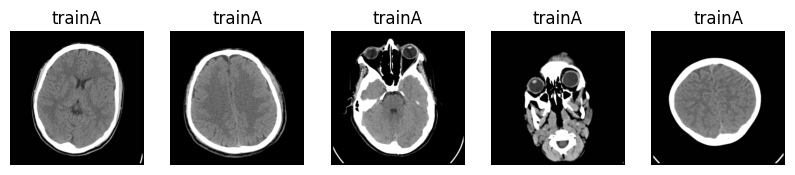

In [13]:
if not df_images.empty:
    print("Images loaded successfully.")
    print(f"Total images loaded: {len(df_images)}")
    
    # Display some basic statistics
    sample_image = df_images['image'].iloc[0]
    print(f"Sample image shape: {sample_image.shape}")
    print(f"Sample image dtype: {sample_image.dtype}")

    consistent_dtype = all(img.dtype == sample_image.dtype for img in df_images['image'])
    min_pixel_value = min(np.min(img) for img in df_images['image'])
    max_pixel_value = max(np.max(img) for img in df_images['image'])
    
    print(f"All images have consistent dtype: {consistent_dtype}")
    print(f"Pixel value range: {min_pixel_value} to {max_pixel_value}")

    shapes = [img.shape for img in df_images['image']]
    consistent_shape = len(set(shapes)) == 1
    
    if consistent_shape:
        print(f"All images have consistent shape: {consistent_shape}")
        if len(sample_image.shape) == 2:
            print("All images are grayscale.")
        elif len(sample_image.shape) == 3:
            if sample_image.shape[2] == 1:
                print("All images are grayscale.")
            elif sample_image.shape[2] == 3:
                print("All images are color (RGB).")
            elif sample_image.shape[2] == 4:
                print("All images are color (RGBA).")
    else:
        print(f"All images have consistent shape: {consistent_shape}")
        grayscale_count = sum(len(shape) == 2 or (len(shape) == 3 and shape[2] == 1) for shape in shapes)
        color_count = len(shapes) - grayscale_count
        print(f"Number of grayscale images: {grayscale_count}")
        print(f"Number of color images: {color_count}")

    # Display a few sample images
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(df_images['image'].iloc[i], cmap='gray')
        plt.title(df_images['label'].iloc[i])
        plt.axis('off')
    plt.show()
else:
    print("No images loaded.")


In [14]:
unique_shapes = set(img.shape for img in df_images['image'])
print(f"Unique image shapes: {unique_shapes}")

Unique image shapes: {(243, 236), (417, 428), (537, 472), (261, 235), (449, 359), (600, 494), (300, 236), (282, 230), (361, 642), (273, 236), (260, 236), (938, 864), (225, 208), (424, 417), (251, 236), (554, 554), (262, 236), (530, 380), (259, 194), (442, 441), (444, 468), (290, 236), (248, 200), (513, 565), (355, 311), (252, 200), (446, 450), (257, 196), (520, 433), (474, 356), (454, 442), (258, 314), (277, 272), (213, 236), (275, 220), (347, 300), (252, 236), (256, 197), (201, 173), (308, 244), (300, 240), (251, 201), (280, 420), (1446, 1375), (872, 850), (234, 215), (236, 212), (280, 212), (485, 407), (540, 504), (197, 177), (231, 218), (832, 825), (400, 393), (879, 766), (231, 236), (586, 467), (340, 314), (252, 222), (236, 214), (283, 231), (279, 258), (256, 256), (380, 310), (337, 293), (304, 235), (192, 192), (221, 228), (198, 150), (264, 235), (725, 728), (253, 278), (225, 225), (338, 276), (248, 208), (301, 275), (777, 622), (680, 680), (938, 911), (349, 278), (245, 224), (369

Images loaded successfully.
Total images loaded: 1500
              mean       median         mode          std           var  \
count  1500.000000  1500.000000  1500.000000  1500.000000   1500.000000   
mean     53.966529    17.850333     2.944667    68.726110   5041.381052   
std      17.467614    29.887789    11.380683    17.841387   2327.527258   
min      17.359077     0.000000     0.000000    25.487901    649.633110   
25%      41.755541     1.000000     0.000000    51.904540   2694.081277   
50%      52.834658     1.000000     1.000000    74.692454   5578.963353   
75%      62.867846    22.000000     1.000000    82.583302   6820.001722   
max     126.615694   159.000000   255.000000   104.854574  10994.481656   

               min          max        entropy  
count  1500.000000  1500.000000    1500.000000  
mean      0.206667    -2.560667   38673.433968  
std       2.011961     8.969427   31965.561853  
min       0.000000  -123.000000    2309.265245  
25%       0.000000    -1.

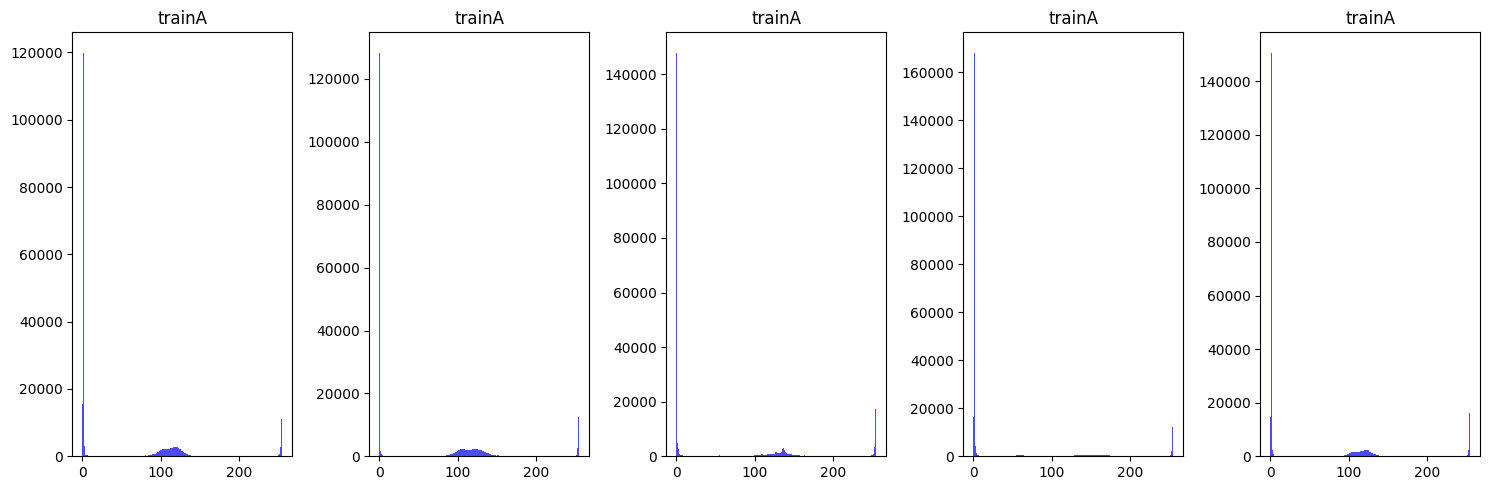

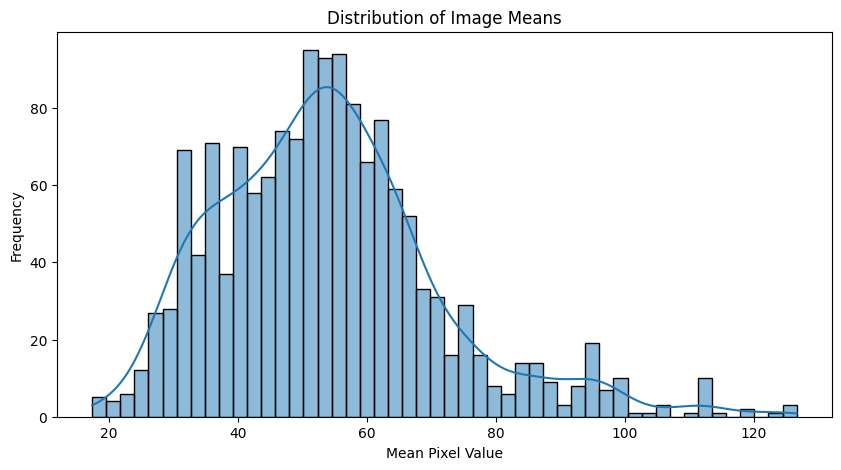

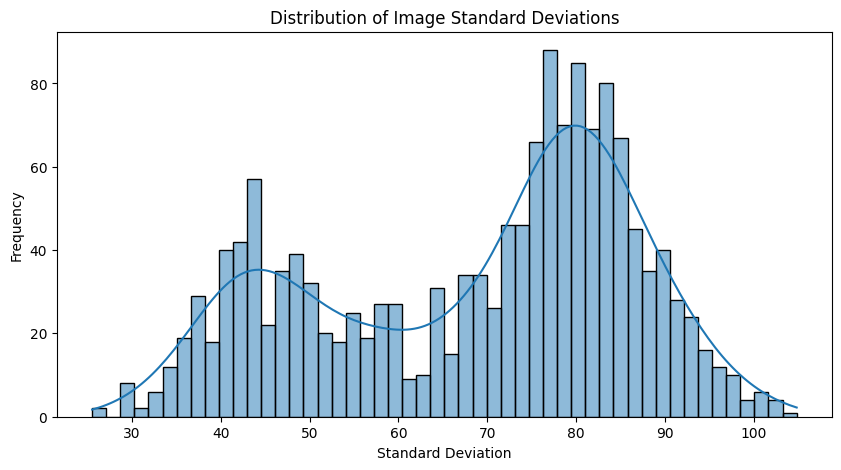

In [16]:
# Statistics and visualizations
def calculate_statistics(image):
    flattened_image = image.flatten()
    return {
        'mean': np.mean(flattened_image),
        'median': np.median(flattened_image),
        'mode': float(pd.Series(flattened_image).mode()[0]),
        'std': np.std(flattened_image),
        'var': np.var(flattened_image),
        'min': np.min(flattened_image),
        'max': np.max(flattened_image),
        'entropy': -np.sum((flattened_image/255.0) * np.log2(flattened_image/255.0 + 1e-9))
    }
    
if not df_images.empty:
    print("Images loaded successfully.")
    print(f"Total images loaded: {len(df_images)}")
    
    # Calculate statistics for each image
    statistics_list = [calculate_statistics(img) for img in df_images['image']]
    df_stats = pd.DataFrame(statistics_list)
    print(df_stats.describe())
    
    df_stats = pd.DataFrame(statistics_list)
    print(df_stats.describe())
    
   # Plot histograms of pixel values for a few sample images
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(df_images))):
        plt.subplot(1, 5, i+1)
        plt.hist(df_images['image'].iloc[i].ravel(), bins=256, color='blue', alpha=0.7)
        plt.title(df_images['label'].iloc[i])
    plt.tight_layout()
    plt.show()
    
    # Plot the distribution of image means and standard deviations
    plt.figure(figsize=(10, 5))
    sns.histplot(df_stats['mean'], bins=50, kde=True)
    plt.title('Distribution of Image Means')
    plt.xlabel('Mean Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.histplot(df_stats['std'], bins=50, kde=True)
    plt.title('Distribution of Image Standard Deviations')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Frequency')
    plt.show()

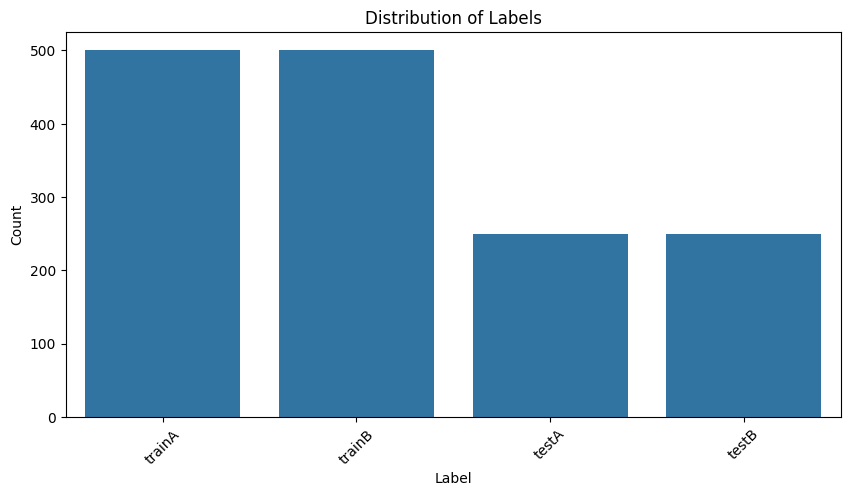

Label Counts:
trainA    500
trainB    500
testA     250
testB     250
Name: label, dtype: int64


In [17]:
# Count the number of images for each label
label_counts = df_images['label'].value_counts()

# Plot label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df_images)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print("Label Counts:")
print(df_images['label'].value_counts())


# Data Pre-Processing & Train-Test Split

2024-08-18 09:53:25.856651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 09:53:25.873714: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 09:53:25.878798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 09:53:25.891375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 09:53:26.712934: W tensorflow/comp

Base path: CT_MRI/Dataset Split/images
trainA_filepaths: ['CT_MRI/Dataset Split/images/trainA/ct1.png', 'CT_MRI/Dataset Split/images/trainA/ct1001.png', 'CT_MRI/Dataset Split/images/trainA/ct1002.png', 'CT_MRI/Dataset Split/images/trainA/ct1003.png', 'CT_MRI/Dataset Split/images/trainA/ct1004.png', 'CT_MRI/Dataset Split/images/trainA/ct1005.png', 'CT_MRI/Dataset Split/images/trainA/ct1006.png', 'CT_MRI/Dataset Split/images/trainA/ct1007.png', 'CT_MRI/Dataset Split/images/trainA/ct101.png', 'CT_MRI/Dataset Split/images/trainA/ct1011.png', 'CT_MRI/Dataset Split/images/trainA/ct1012.png', 'CT_MRI/Dataset Split/images/trainA/ct1013.png', 'CT_MRI/Dataset Split/images/trainA/ct1014.png', 'CT_MRI/Dataset Split/images/trainA/ct1015.png', 'CT_MRI/Dataset Split/images/trainA/ct1016.png', 'CT_MRI/Dataset Split/images/trainA/ct1017.png', 'CT_MRI/Dataset Split/images/trainA/ct102.png', 'CT_MRI/Dataset Split/images/trainA/ct1021.png', 'CT_MRI/Dataset Split/images/trainA/ct1022.png', 'CT_MRI/Dataset 

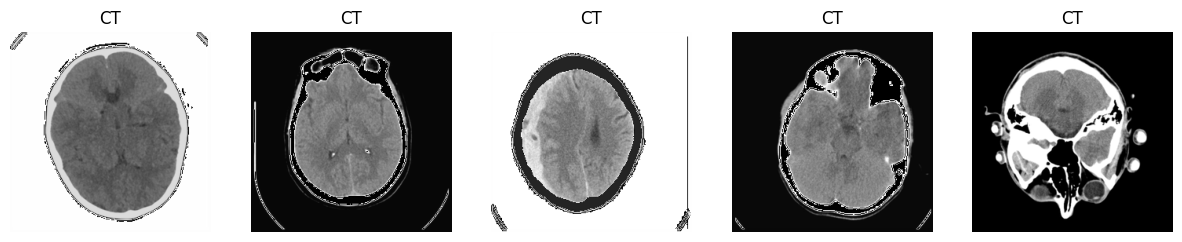

Train MRI Images


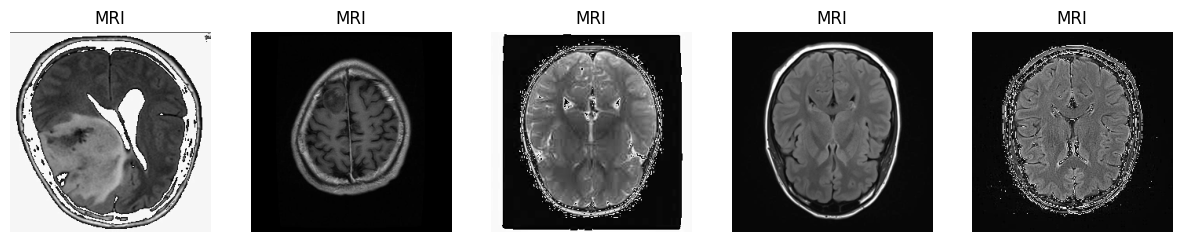

In [1]:
# Image preprocessing function
def preprocess_image(image_array, target_size=(256, 256)):
    image = Image.fromarray(image_array)
    image = image.resize(target_size, Image.Resampling.LANCZOS)
    image_array = np.array(image)
    if len(image_array.shape) == 2:
        image_array = np.expand_dims(image_array, axis=-1)
    normalized_image_array = (image_array / 127.5) - 1.0
    return normalized_image_array

# Function to apply random jittering
def random_jitter(image):
    # Convert to tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Random horizontal and vertical flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random zoom (crop and resize)
    image = tf.image.random_crop(image, size=[256, 256, 1])
    image = tf.image.resize(image, [256, 256])
    
    return image


# Function to load images from given filepaths
def load_images(filepaths):
    images = []
    for path in filepaths:
        try:
            print(f"Loading image from: {path}")  
            image = Image.open(path).convert('L')  
            image = np.array(image)
            images.append(image)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return images

# Load images from directories using glob
def load_dataset(base_path):
    print(f"Base path: {base_path}")
    
    # Use glob to find images in each directory
    trainA_filepaths = glob.glob(os.path.join(base_path, 'trainA', '*'))
    trainB_filepaths = glob.glob(os.path.join(base_path, 'trainB', '*'))
    testA_filepaths = glob.glob(os.path.join(base_path, 'testA', '*'))
    testB_filepaths = glob.glob(os.path.join(base_path, 'testB', '*'))
    
    print(f"trainA_filepaths: {trainA_filepaths}")
    print(f"trainB_filepaths: {trainB_filepaths}")
    print(f"testA_filepaths: {testA_filepaths}")
    print(f"testB_filepaths: {testB_filepaths}")

    trainA_images = load_images(trainA_filepaths)
    trainB_images = load_images(trainB_filepaths)
    testA_images = load_images(testA_filepaths)
    testB_images = load_images(testB_filepaths)
    
    return trainA_images, trainB_images, testA_images, testB_images

# Function to display images
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i+1)
        image = (images[i] + 1.0) * 127.5  # Reverse normalization
        image = image.astype(np.uint8)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title('CT' if labels[i] == 0 else 'MRI')
        plt.axis('off')
    plt.show()

# Split data into training and validation sets
def split_data(images, labels, test_size=0.2):
    return train_test_split(images, labels, test_size=test_size, random_state=42)

# Create TensorFlow datasets
def create_tf_dataset(images, labels, batch_size=1):
    if len(images) == 0:
        raise ValueError("No images to create a TensorFlow dataset.")
    
    # Convert to TensorFlow tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (random_jitter(x), y))  
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Main function to preprocess and split datasets
def preprocess_and_split_datasets(base_path, target_size=(256, 256), batch_size=1):
    trainA_images, trainB_images, testA_images, testB_images = load_dataset(base_path)

    # Check if any images are loaded
    if not trainA_images:
        raise ValueError("No images found in trainA directory.")
    if not trainB_images:
        raise ValueError("No images found in trainB directory.")
    if not testA_images:
        raise ValueError("No images found in testA directory.")
    if not testB_images:
        raise ValueError("No images found in testB directory.")

    print(f"Number of images in trainA: {len(trainA_images)}")
    print(f"Number of images in trainB: {len(trainB_images)}")
    print(f"Number of images in testA: {len(testA_images)}")
    print(f"Number of images in testB: {len(testB_images)}")

    # Preprocess images
    trainA_images = np.array([preprocess_image(image, target_size) for image in trainA_images])
    trainB_images = np.array([preprocess_image(image, target_size) for image in trainB_images])
    testA_images = np.array([preprocess_image(image, target_size) for image in testA_images])
    testB_images = np.array([preprocess_image(image, target_size) for image in testB_images])

    trainA_labels = np.zeros(len(trainA_images))
    trainB_labels = np.ones(len(trainB_images))
    testA_labels = np.zeros(len(testA_images))
    testB_labels = np.ones(len(testB_images))

    # Split into training and validation sets
    trainA_train_images, trainA_val_images, trainA_train_labels, trainA_val_labels = split_data(trainA_images, trainA_labels, test_size=0.2)
    trainB_train_images, trainB_val_images, trainB_train_labels, trainB_val_labels = split_data(trainB_images, trainB_labels, test_size=0.2)

    # Create TensorFlow datasets
    trainA_dataset = create_tf_dataset(trainA_train_images, trainA_train_labels, batch_size)
    valA_dataset = create_tf_dataset(trainA_val_images, trainA_val_labels, batch_size)
    trainB_dataset = create_tf_dataset(trainB_train_images, trainB_train_labels, batch_size)
    valB_dataset = create_tf_dataset(trainB_val_images, trainB_val_labels, batch_size)

    return trainA_dataset, valA_dataset, trainB_dataset, valB_dataset

# Base path to the dataset
base_path = 'CT_MRI/Dataset Split/images'  
target_size = (256, 256)
batch_size = 16

train_ct_dataset, val_ct_dataset, train_mri_dataset, val_mri_dataset = preprocess_and_split_datasets(base_path, target_size, batch_size)

# Get a batch of images and labels from each dataset
train_ct_batch = next(iter(train_ct_dataset))
train_mri_batch = next(iter(train_mri_dataset))

# Display the images
print("Train CT Images")
display_images(train_ct_batch[0].numpy(), train_ct_batch[1].numpy())

print("Train MRI Images")
display_images(train_mri_batch[0].numpy(), train_mri_batch[1].numpy())


In [2]:
# Check the range of pixel values after preprocessing
print(f"Min pixel value: {train_ct_batch[0].numpy().min()}")
print(f"Max pixel value: {train_ct_batch[0].numpy().max()}")

Min pixel value: -1.0940525531768799
Max pixel value: 1.3514831066131592


In [3]:
def get_dataset_length(dataset):
    length = sum(1 for _ in dataset)
    return length

# Calculate lengths of the datasets
train_ct_length = get_dataset_length(train_ct_dataset)
val_ct_length = get_dataset_length(val_ct_dataset)
train_mri_length = get_dataset_length(train_mri_dataset)
val_mri_length = get_dataset_length(val_mri_dataset)

# Print the lengths
print(f"Length of train CT dataset: {train_ct_length * batch_size} images")
print(f"Length of validation CT dataset: {val_ct_length * batch_size} images")
print(f"Length of train MRI dataset: {train_mri_length * batch_size} images")
print(f"Length of validation MRI dataset: {val_mri_length * batch_size} images")


2024-08-18 09:54:18.808743: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-18 09:54:18.885141: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-18 09:54:19.111790: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Length of train CT dataset: 400 images
Length of validation CT dataset: 112 images
Length of train MRI dataset: 400 images
Length of validation MRI dataset: 112 images


In [4]:
# Inspecting the output of the datasets
for ct_images, _ in train_ct_dataset.take(1):
    print("CT Images batch shape:", ct_images.shape)

for mri_images, _ in train_mri_dataset.take(1):
    print("MRI Images batch shape:", mri_images.shape)

CT Images batch shape: (16, 256, 256, 1)
MRI Images batch shape: (16, 256, 256, 1)


In [5]:
train_ct_dataset = train_ct_dataset.map(lambda x, y: x)
train_mri_dataset = train_mri_dataset.map(lambda x, y: x)

## Self Attention mechanism


In [6]:
# Utility Functions
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

def generator_loss(disc_generated_output):
    return tf.reduce_mean(tf.math.squared_difference(disc_generated_output, 1.0))

def discriminator_loss(disc_real_output, disc_generated_output, label_smoothing=False):
    if label_smoothing:
        # Apply label smoothing
        real_labels = tf.ones_like(disc_real_output) * 0.9
        fake_labels = tf.zeros_like(disc_generated_output) * 0.1
    else:
        real_labels = tf.ones_like(disc_real_output)
        fake_labels = tf.zeros_like(disc_generated_output)
    
    real_loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(real_labels, disc_real_output))
    generated_loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(fake_labels, disc_generated_output))
    
    return real_loss + generated_loss

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(SelfAttention, self).__init__()
        self.filters = filters

    def build(self, input_shape):
        self.query_conv = Conv2D(self.filters, kernel_size=1, padding='same')
        self.key_conv = Conv2D(self.filters, kernel_size=1, padding='same')
        self.value_conv = Conv2D(self.filters, kernel_size=1, padding='same')
        self.out_conv = Conv2D(input_shape[-1], kernel_size=1, padding='same')

    def call(self, inputs):
        batch_size, height, width, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        
        # Compute query, key, and value
        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)
        
        # Reshape for attention calculation
        query_reshape = tf.reshape(query, [batch_size, height * width, self.filters])
        key_reshape = tf.reshape(key, [batch_size, height * width, self.filters])
        value_reshape = tf.reshape(value, [batch_size, height * width, self.filters])
        
        # Compute attention weights
        attention_weights = tf.nn.softmax(tf.linalg.matmul(query_reshape, key_reshape, transpose_b=True), axis=-1)
        
        # Compute attention output
        attention_output = tf.linalg.matmul(attention_weights, value_reshape)
        attention_output = tf.reshape(attention_output, [batch_size, height, width, self.filters])
        
        # Output convolution
        output = self.out_conv(attention_output)
        return output

## Generator Initialization

In [7]:
def build_generator(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(1, 4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Adding Self-Attention after downsampling
    x = SelfAttention(filters=512)(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        if x.shape[1:] != skip.shape[1:]:
            skip = Conv2D(filters=skip.shape[-1], kernel_size=1, padding='same')(skip)
        x = Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Discriminator Initialization

In [8]:
def build_discriminator(input_shape=(256, 256, 1)):
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape=input_shape, name='input_image')
    tar = Input(shape=input_shape, name='target_image')

    x = Concatenate()([inp, tar])

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1,
                  kernel_initializer=initializer,
                  use_bias=False)(zero_pad1)

    norm1 = BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(norm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu)

    last = Conv2D(1, 4, strides=1,
                  kernel_initializer=initializer)(zero_pad2)

    return Model(inputs=[inp, tar], outputs=last)

## Loss function

In [9]:
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))
    
@tf.function
def train_step(real_ct_images, real_mri_images):
    with tf.GradientTape() as tape_g, \
         tf.GradientTape() as tape_f, \
         tf.GradientTape() as tape_d_x, \
         tf.GradientTape() as tape_d_y:
        
        # Generate fake images and cycle them
        fake_mri_images = generator_g(real_ct_images, training=True)
        cycled_ct_images = generator_f(fake_mri_images, training=True)
        
        fake_ct_images = generator_f(real_mri_images, training=True)
        cycled_mri_images = generator_g(fake_ct_images, training=True)

        # Discriminator outputs
        disc_real_ct = discriminator_x([real_ct_images, real_mri_images], training=True)
        disc_fake_ct = discriminator_x([fake_ct_images, real_mri_images], training=True)

        disc_real_mri = discriminator_y([real_mri_images, real_ct_images], training=True)
        disc_fake_mri = discriminator_y([fake_mri_images, real_ct_images], training=True)

        # Losses for generators
        gen_g_loss = generator_loss(disc_fake_mri)
        gen_f_loss = generator_loss(disc_fake_ct)
        
        # Losses for discriminators with label smoothing
        disc_x_loss = discriminator_loss(disc_real_ct, disc_fake_ct, label_smoothing=True)
        disc_y_loss = discriminator_loss(disc_real_mri, disc_fake_mri, label_smoothing=True)

        # L1 Losses for cycle consistency
        cycle_loss_ct = l1_loss(real_ct_images, cycled_ct_images)
        cycle_loss_mri = l1_loss(real_mri_images, cycled_mri_images)

        # L1 Losses for identity mapping
        identity_loss_ct = l1_loss(real_mri_images, generator_g(real_mri_images, training=True))
        identity_loss_mri = l1_loss(real_ct_images, generator_f(real_ct_images, training=True))

        # Total generator losses
        total_gen_g_loss = gen_g_loss + 20 * cycle_loss_ct + 1 * identity_loss_mri
        total_gen_f_loss = gen_f_loss + 20 * cycle_loss_mri + 1 * identity_loss_ct

        # Feature matching loss (placeholder, to be implemented based on your architecture)
        feature_matching_loss_g = feature_matching_loss(real_mri_images, fake_mri_images, generator_g)
        feature_matching_loss_f = feature_matching_loss(real_ct_images, fake_ct_images, generator_f)
        
        total_gen_g_loss += feature_matching_loss_g
        total_gen_f_loss += feature_matching_loss_f

    # Compute gradients
    gradients_of_generator_g = tape_g.gradient(total_gen_g_loss, generator_g.trainable_variables)
    gradients_of_generator_f = tape_f.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    gradients_of_discriminator_x = tape_d_x.gradient(disc_x_loss, discriminator_x.trainable_variables)
    gradients_of_discriminator_y = tape_d_y.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradient clipping
    gradients_of_generator_g = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients_of_generator_g]
    gradients_of_generator_f = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients_of_generator_f]

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(gradients_of_generator_g, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(gradients_of_generator_f, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(gradients_of_discriminator_x, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(gradients_of_discriminator_y, discriminator_y.trainable_variables))

    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_x_loss': disc_x_loss,
        'disc_y_loss': disc_y_loss,
        'cycle_loss_ct': cycle_loss_ct,
        'cycle_loss_mri': cycle_loss_mri,
        'identity_loss_ct': identity_loss_ct,
        'identity_loss_mri': identity_loss_mri
    }

def feature_matching_loss(real_images, generated_images, generator):
    # This is a placeholder for feature matching loss implementation
    real_features = generator(real_images, training=False)
    generated_features = generator(generated_images, training=False)
    return tf.reduce_mean(tf.abs(real_features - generated_features))

## Model Checkpoints

In [10]:
def create_checkpoint(generator_g, generator_f, discriminator_x, discriminator_y,
                       generator_g_optimizer, generator_f_optimizer,
                       discriminator_x_optimizer, discriminator_y_optimizer,
                       checkpoint_dir='checkpoints'):
    epoch = tf.Variable(0, dtype=tf.int64)
    checkpoint = tf.train.Checkpoint(
        generator_g=generator_g,
        generator_f=generator_f,
        discriminator_x=discriminator_x,
        discriminator_y=discriminator_y,
        generator_g_optimizer=generator_g_optimizer,
        generator_f_optimizer=generator_f_optimizer,
        discriminator_x_optimizer=discriminator_x_optimizer,
        discriminator_y_optimizer=discriminator_y_optimizer,
        epoch=epoch
    )
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
    return checkpoint, checkpoint_manager

def save_checkpoint(checkpoint, checkpoint_manager, epoch):
    checkpoint.epoch.assign(epoch)
    checkpoint_manager.save()


## Model Training 

In [11]:
def scheduler(epoch, lr):
    initial_lr = 0.0002
    decay_rate = 0.1
    decay_epochs = 150
    if epoch < decay_epochs:
        return lr
    else:
        return initial_lr * tf.math.exp(-decay_rate * (epoch - decay_epochs))

# Define the learning rate scheduler callback
def lr_schedule(epoch, lr):
    return scheduler(epoch, lr)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

def train(train_ct_dataset, train_mri_dataset, val_ct_dataset, val_mri_dataset, epochs, checkpoint_dir='checkpoints'):
    # Create or restore from checkpoint
    checkpoint, checkpoint_manager = create_checkpoint(generator_g, generator_f, discriminator_x, discriminator_y,
                                                       generator_g_optimizer, generator_f_optimizer,
                                                       discriminator_x_optimizer, discriminator_y_optimizer,
                                                       checkpoint_dir)
    if checkpoint_manager.latest_checkpoint:
        checkpoint.restore(checkpoint_manager.latest_checkpoint)
        print(f"Restored from {checkpoint_manager.latest_checkpoint}")
    else:
        print("No checkpoint found. Initializing from scratch.")

    # Initialize history dictionary
    history = {
        'gen_g_loss': [],
        'gen_f_loss': [],
        'disc_x_loss': [],
        'disc_y_loss': [],
        'cycle_loss_ct': [],
        'cycle_loss_mri': [],
        'identity_loss_ct': [],
        'identity_loss_mri': []
    }

    # Training loop
    for epoch in range(checkpoint.epoch.numpy(), epochs):
        start_time = time.time()

        # Update the learning rate using the scheduler
        new_lr = scheduler(epoch, generator_g_optimizer.learning_rate.numpy())
        generator_g_optimizer.learning_rate.assign(new_lr)
        generator_f_optimizer.learning_rate.assign(new_lr)
        discriminator_x_optimizer.learning_rate.assign(new_lr)
        discriminator_y_optimizer.learning_rate.assign(new_lr)

        print(f"Epoch {epoch + 1}/{epochs}, Learning Rate: {new_lr:.6f}")

        # Initialize loss metrics
        epoch_gen_g_loss = 0
        epoch_gen_f_loss = 0
        epoch_disc_x_loss = 0
        epoch_disc_y_loss = 0
        epoch_cycle_loss_ct = 0
        epoch_cycle_loss_mri = 0
        epoch_identity_loss_ct = 0
        epoch_identity_loss_mri = 0

        # Loop for epochs 
        for real_ct_images, real_mri_images in tqdm(zip(train_ct_dataset, train_mri_dataset), total=len(train_ct_dataset)):
            losses = train_step(real_ct_images, real_mri_images)
            
            # Accumulate losses
            epoch_gen_g_loss += losses['gen_g_loss']
            epoch_gen_f_loss += losses['gen_f_loss']
            epoch_disc_x_loss += losses['disc_x_loss']
            epoch_disc_y_loss += losses['disc_y_loss']
            epoch_cycle_loss_ct += losses['cycle_loss_ct']
            epoch_cycle_loss_mri += losses['cycle_loss_mri']
            epoch_identity_loss_ct += losses['identity_loss_ct']
            epoch_identity_loss_mri += losses['identity_loss_mri']

        # Calculate average losses for the epoch
        num_batches = len(train_ct_dataset)
        epoch_gen_g_loss /= num_batches
        epoch_gen_f_loss /= num_batches
        epoch_disc_x_loss /= num_batches
        epoch_disc_y_loss /= num_batches
        epoch_cycle_loss_ct /= num_batches
        epoch_cycle_loss_mri /= num_batches
        epoch_identity_loss_ct /= num_batches
        epoch_identity_loss_mri /= num_batches

        # Append losses to history
        history['gen_g_loss'].append(epoch_gen_g_loss)
        history['gen_f_loss'].append(epoch_gen_f_loss)
        history['disc_x_loss'].append(epoch_disc_x_loss)
        history['disc_y_loss'].append(epoch_disc_y_loss)
        history['cycle_loss_ct'].append(epoch_cycle_loss_ct)
        history['cycle_loss_mri'].append(epoch_cycle_loss_mri)
        history['identity_loss_ct'].append(epoch_identity_loss_ct)
        history['identity_loss_mri'].append(epoch_identity_loss_mri)

        # Epoch time
        epoch_time = time.time() - start_time

    
        print(f'Epoch {epoch + 1}/{epochs}, Time taken: {epoch_time:.2f} seconds')
        print(f'Generator G Loss: {epoch_gen_g_loss:.4f}')
        print(f'Generator F Loss: {epoch_gen_f_loss:.4f}')
        print(f'Discriminator X Loss: {epoch_disc_x_loss:.4f}')
        print(f'Discriminator Y Loss: {epoch_disc_y_loss:.4f}')
        print(f'Cycle Loss CT: {epoch_cycle_loss_ct:.4f}')
        print(f'Cycle Loss MRI: {epoch_cycle_loss_mri:.4f}')
        print(f'Identity Loss CT: {epoch_identity_loss_ct:.4f}')
        print(f'Identity Loss MRI: {epoch_identity_loss_mri:.4f}')

        save_checkpoint(checkpoint, checkpoint_manager, epoch + 1)
        print(f"Checkpoint saved at epoch {epoch + 1}")
        print(f"Status: Epoch {epoch + 1} completed successfully")

    print(f"Training finished in {time.time() - start_time} seconds")
    return history

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Model Intialization
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

# Train the model
train(train_ct_dataset, train_mri_dataset, val_ct_dataset, val_mri_dataset, epochs=100, checkpoint_dir='checkpoints')

Restored from checkpoints/ckpt-37
Epoch 38/100, Learning Rate: 0.000200
Epoch 38/100, Time taken: 314.07 seconds
Generator G Loss: 18.4860
Generator F Loss: 16.1183
Discriminator X Loss: 3.4433
Discriminator Y Loss: 3.5516
Cycle Loss CT: 0.7686
Cycle Loss MRI: 0.6709
Identity Loss CT: 0.6761
Identity Loss MRI: 0.7579
Checkpoint saved at epoch 38
Status: Epoch 38 completed successfully
Epoch 39/100, Learning Rate: 0.000200
Epoch 39/100, Time taken: 287.34 seconds
Generator G Loss: 14.6658
Generator F Loss: 12.7962
Discriminator X Loss: 0.6588
Discriminator Y Loss: 0.7492
Cycle Loss CT: 0.6647
Cycle Loss MRI: 0.5754
Identity Loss CT: 0.5843
Identity Loss MRI: 0.6619
Checkpoint saved at epoch 39
Status: Epoch 39 completed successfully
Epoch 40/100, Learning Rate: 0.000200
Epoch 40/100, Time taken: 285.96 seconds
Generator G Loss: 12.5260
Generator F Loss: 11.0325
Discriminator X Loss: 0.4804
Discriminator Y Loss: 0.4817
Cycle Loss CT: 0.5649
Cycle Loss MRI: 0.4899
Identity Loss CT: 0.5036

100%|██████████| 25/25 [04:45<00:00, 11.43s/it]2024-08-18 10:44:22.901516: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

  8%|▊         | 2/25 [00:34<06:36, 17.25s/it]


KeyboardInterrupt: 

## Model Evaluation

In [47]:
def evaluate_model(val_ct_dataset, val_mri_dataset, num_samples=5, epoch=0):
    total_cycle_loss_ct = 0
    total_cycle_loss_mri = 0
    total_identity_loss_ct = 0
    total_identity_loss_mri = 0
    
    num_batches = 0
    original_ct_images = []
    original_mri_images = []
    fake_mri_images = []
    fake_ct_images = []
    cycled_ct_images = []
    cycled_mri_images = []

    for val_ct_batch, val_mri_batch in zip(val_ct_dataset, val_mri_dataset):
        val_ct_images = val_ct_batch[0]  
        val_mri_images = val_mri_batch[0]  
        val_ct_images = tf.cast(val_ct_images, tf.float32)
        val_mri_images = tf.cast(val_mri_images, tf.float32)

        fake_mri_images_batch = generator_g(val_ct_images, training=False)
        fake_ct_images_batch = generator_f(val_mri_images, training=False)
        cycled_ct_images_batch = generator_f(fake_mri_images_batch, training=False)
        cycled_mri_images_batch = generator_g(fake_ct_images_batch, training=False)

        identity_loss_ct = tf.reduce_mean(tf.abs(val_mri_images - generator_g(val_mri_images, training=False)))
        identity_loss_mri = tf.reduce_mean(tf.abs(val_ct_images - generator_f(val_ct_images, training=False)))
        
        cycle_loss_ct = tf.reduce_mean(tf.abs(val_ct_images - cycled_ct_images_batch))
        cycle_loss_mri = tf.reduce_mean(tf.abs(val_mri_images - cycled_mri_images_batch))

        total_cycle_loss_mri += cycle_loss_mri.numpy()
        total_identity_loss_mri += identity_loss_mri.numpy()

        original_ct_images.append(val_ct_images.numpy())
        original_mri_images.append(val_mri_images.numpy())
        fake_mri_images.append(fake_mri_images_batch.numpy())
        fake_ct_images.append(fake_ct_images_batch.numpy())
        cycled_ct_images.append(cycled_ct_images_batch.numpy())
        cycled_mri_images.append(cycled_mri_images_batch.numpy())

        num_batches += 1
        if num_batches >= num_samples:
            break

    avg_cycle_loss_mri = total_cycle_loss_mri / num_batches
    avg_identity_loss_mri = total_identity_loss_mri / num_batches
    return avg_cycle_loss_mri, avg_identity_loss_mri
    
    


    

In [49]:
    avg_cycle_loss_ct, avg_cycle_loss_mri, avg_identity_loss_ct, avg_identity_loss_mri = evaluate_model(val_ct_dataset, val_mri_dataset, num_samples=5, epoch=7)
    print(f"Average Cycle Loss MRI: {avg_cycle_loss_mri}")
    print(f"Average Identity Loss MRI: {avg_identity_loss_mri}")

Average Cycle Loss MRI: 0.7378138303756714
Average Identity Loss MRI: 0.23844395875930785


## Generated Image Visualization for Model Evaluation

In [31]:
def visualize_images(generator_g, generator_f, val_ct_dataset, val_mri_dataset, epoch):
    try:
        val_ct_batch, _ = next(iter(val_ct_dataset))  
        val_mri_batch, _ = next(iter(val_mri_dataset)) 
    except StopIteration:
        raise RuntimeError("Validation dataset is empty or not iterable.")
    
    print(f'Validation CT Batch Shape: {val_ct_batch.shape}')
    print(f'Validation MRI Batch Shape: {val_mri_batch.shape}')

    val_ct_batch = tf.cast(val_ct_batch, tf.float32)
    val_mri_batch = tf.cast(val_mri_batch, tf.float32)

    generated_mri_images = generator_g(val_ct_batch, training=False)
    generated_ct_images = generator_f(val_mri_batch, training=False)

    plt.figure(figsize=(15, 15))

    # Plot 
    plt.figure(figsize=(20, 20))

    for i in range(min(len(val_mri_batch), 2)):  
        plt.subplot(5, 2, 2 * i + 1)
        plt.title(f'Real MRI Image {i+1}')
        plt.imshow(val_mri_batch[i, :, :, 0] * 0.5 + 0.5, cmap='gray')  
        plt.axis('off')

        plt.subplot(5, 2, 2 * i + 2)
        plt.title(f'Generated CT Image {i+1}')
        plt.imshow(generated_ct_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray') 
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'epoch_{epoch+1}_generated_images_2.png')
    plt.show()


Validation CT Batch Shape: (16, 256, 256, 1)
Validation MRI Batch Shape: (16, 256, 256, 1)


<Figure size 1500x1500 with 0 Axes>

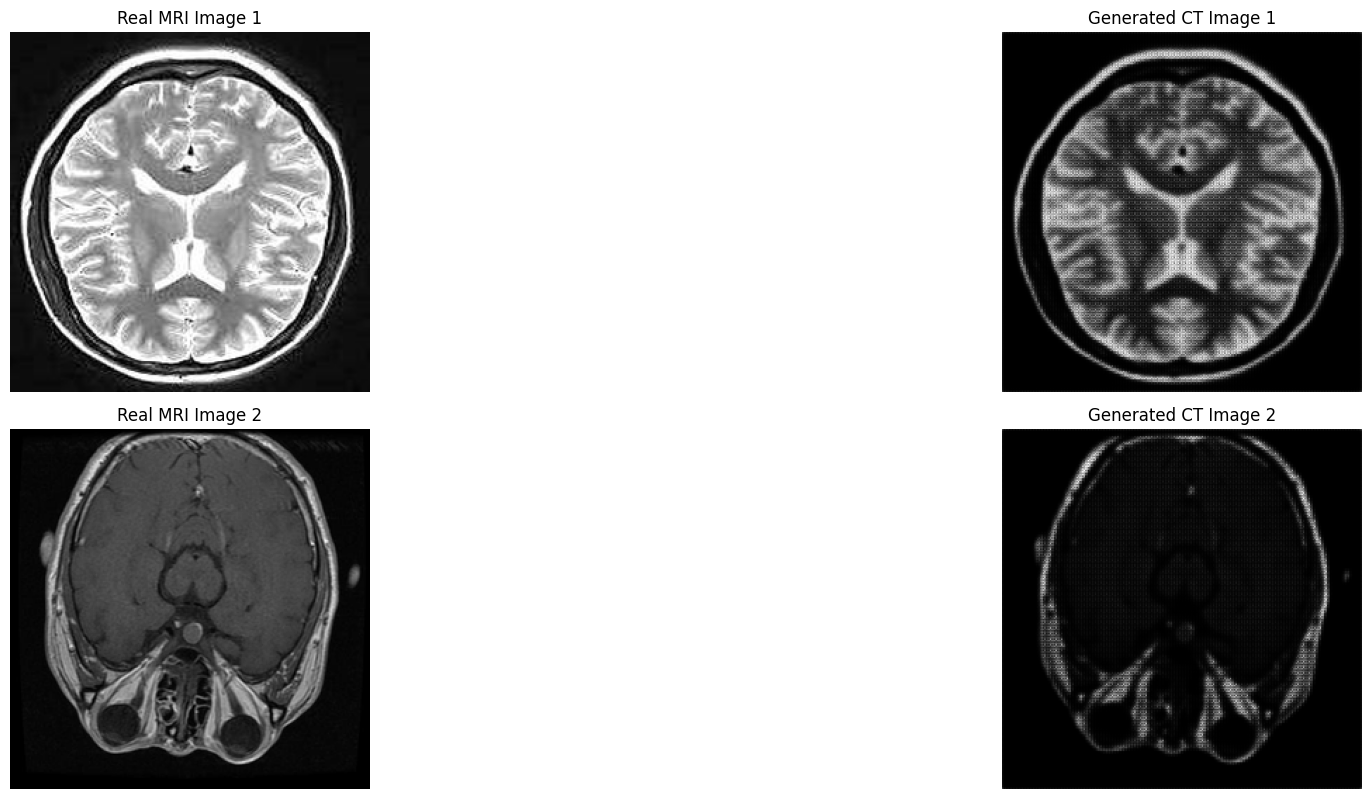

In [32]:
# Visualize images
visualize_images(generator_g, generator_f, val_ct_dataset, val_mri_dataset, epoch=51)  

Evaluation Results for MRI to CT Translation:
Average Generator F Loss: 1.5349
Average Cycle Loss MRI: 0.7374
Average Identity Loss CT: 0.3314


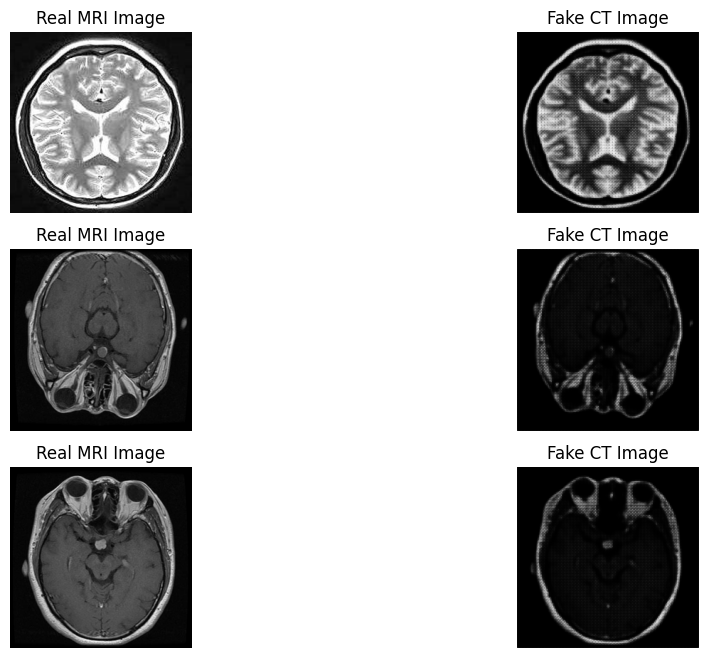

In [36]:
@tf.function
def evaluate_step_mri_to_ct(real_mri_images):
    fake_ct_images = generator_f(real_mri_images, training=False)
    disc_fake_ct = discriminator_x([fake_ct_images, real_mri_images], training=False)
    gen_f_loss = generator_loss(disc_fake_ct)
    
    # L1 loss for cycle consistency
    cycled_mri_images = generator_g(fake_ct_images, training=False)
    cycle_loss_mri = l1_loss(real_mri_images, cycled_mri_images)
    
    # identity loss
    identity_loss_ct = l1_loss(real_mri_images, generator_f(real_mri_images, training=False))

    return {
        'gen_f_loss': gen_f_loss,
        'cycle_loss_mri': cycle_loss_mri,
        'identity_loss_ct': identity_loss_ct,
        'fake_ct_images': fake_ct_images
    }

def evaluate_mri_to_ct(val_mri_dataset):

    total_gen_f_loss = 0
    total_cycle_loss_mri = 0
    total_identity_loss_ct = 0
    num_batches = 0


    for real_mri_images in val_mri_dataset:
        if isinstance(real_mri_images, tuple):
            real_mri_images = real_mri_images[0]  
        metrics = evaluate_step_mri_to_ct(real_mri_images)
        
        total_gen_f_loss += metrics['gen_f_loss'].numpy()
        total_cycle_loss_mri += metrics['cycle_loss_mri'].numpy()
        total_identity_loss_ct += metrics['identity_loss_ct'].numpy()
        
        num_batches += 1

    # Calculate average losses
    avg_gen_f_loss = total_gen_f_loss / num_batches
    avg_cycle_loss_mri = total_cycle_loss_mri / num_batches
    avg_identity_loss_ct = total_identity_loss_ct / num_batches

    # Print average losses
    print("Evaluation Results for MRI to CT Translation:")
    print(f"Average Generator F Loss: {avg_gen_f_loss:.4f}")
    print(f"Average Cycle Loss MRI: {avg_cycle_loss_mri:.4f}")
    print(f"Average Identity Loss CT: {avg_identity_loss_ct:.4f}")

    # Visualize some results
    for real_mri_images in val_mri_dataset:
        if isinstance(real_mri_images, tuple):
            real_mri_images = real_mri_images[0] 
        
        metrics = evaluate_step_mri_to_ct(real_mri_images)
        fake_ct_images = metrics['fake_ct_images'].numpy()

        # Visualize images
        plt.figure(figsize=(12, 8))
        for i in range(min(3, real_mri_images.shape[0])):
            plt.subplot(3, 2, 2 * i + 1)
            plt.title('Real MRI Image')
            plt.imshow((real_mri_images[i] + 1) / 2, cmap='gray')
            plt.axis('off')

            plt.subplot(3, 2, 2 * i + 2)
            plt.title('Fake CT Image')
            plt.imshow((fake_ct_images[i] + 1) / 2, cmap='gray')
            plt.axis('off')

        plt.show()
        break 

evaluate_mri_to_ct(val_mri_dataset)

In [50]:
# MSE functions
def compute_mse(image1, image2):
    return tf.reduce_mean(tf.square(image1 - image2)).numpy()

def evaluate_images(real_images, generated_images):
    for i in range(len(real_images)):
        real_image = real_images[i]
        generated_image = generated_images[i]
        
        if len(real_image.shape) == 3:  
            real_image = tf.expand_dims(real_image, axis=-1)
        if len(generated_image.shape) == 3:
            generated_image = tf.expand_dims(generated_image, axis=-1)
        
        # Compute MSE
        mse = compute_mse(real_image, generated_image)
        print(f'MSE for image {i}: {mse:.4f}')

real_images = [tf.random.uniform((256, 256, 1)) for _ in range(5)] 
generated_images = [tf.random.uniform((256, 256, 1)) for _ in range(5)] 

evaluate_images(real_images, generated_images)

MSE for image 0: 0.1662
MSE for image 1: 0.1673
MSE for image 2: 0.1672
MSE for image 3: 0.1677
MSE for image 4: 0.1672


## Visualization of the losses

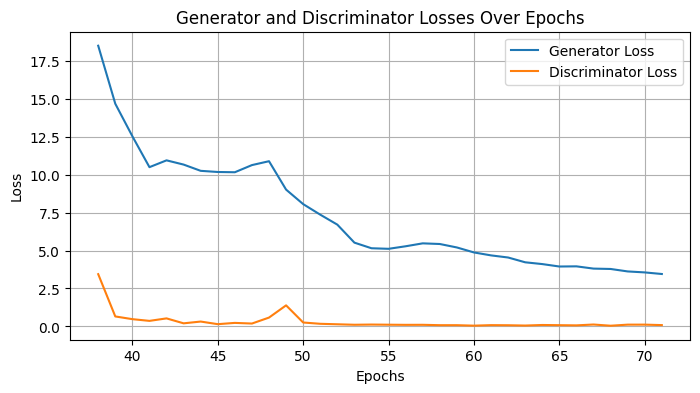

In [11]:
import matplotlib.pyplot as plt


epochs = list(range(38, 72))

# Generator and Discriminator Losses manually stored in the variable
generator_losses = [18.4860, 14.6658, 12.5260, 10.4892, 10.9378, 10.6590, 10.2475, 10.1712, 10.1546, 10.6251, 10.8812, 9.0112, 8.0564, 7.3612, 6.7048, 5.5189, 5.1494, 5.1124, 5.2797, 5.4722, 5.4289, 5.2014, 4.8730, 4.6794, 4.5396, 4.2242, 4.1069, 3.9468, 3.9580, 3.8091, 3.7850, 3.6228, 3.5584, 3.4537]
discriminator_losses = [3.4433, 0.6588, 0.4804, 0.3669, 0.5311, 0.2054, 0.3223, 0.1502, 0.2340, 0.1910, 0.5841, 1.3887, 0.2601, 0.1746, 0.1428, 0.1113, 0.1245, 0.1146, 0.1055, 0.1081, 0.0831, 0.0829, 0.0522, 0.0860, 0.0791, 0.0593, 0.0961, 0.0832, 0.0713, 0.1272, 0.0479, 0.1188, 0.1195, 0.0887]

# Plotting the losses
plt.figure(figsize=(8, 4))
plt.plot(epochs, generator_losses, label='Generator Loss')
plt.plot(epochs, discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


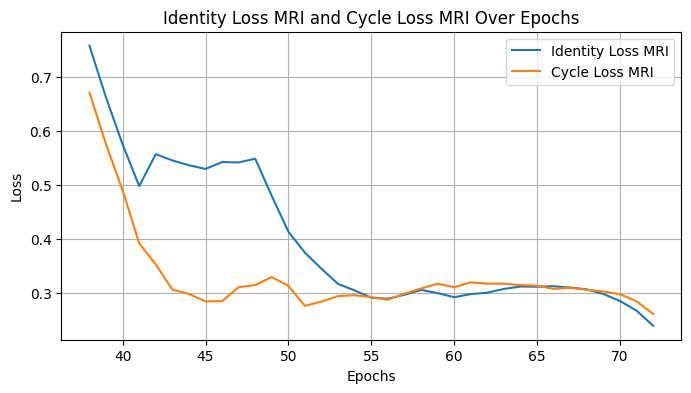

In [10]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(38, 73)) 

# Identity Loss MRI and Cycle Loss MRI manually stored in the variable
identity_loss_mri = [0.7579, 0.6619, 0.5750, 0.4979, 0.5569, 0.5454, 0.5364, 0.5296, 0.5423, 0.5417, 0.5485, 0.4793, 0.4133, 0.3744, 0.3445, 0.3164, 0.3045, 0.2910, 0.2891, 0.2965, 0.3054, 0.2996, 0.2919, 0.2977, 0.3003, 0.3073, 0.3117, 0.3114, 0.3123, 0.3097, 0.3065, 0.2979, 0.2850, 0.2671, 0.2391]
cycle_loss_mri = [0.6709, 0.5754, 0.4899, 0.3918, 0.3527, 0.3061, 0.2980, 0.2841, 0.2847, 0.3104, 0.3145, 0.3293, 0.3129, 0.2759, 0.2839, 0.2941, 0.2956, 0.2920, 0.2873, 0.2984, 0.3081, 0.3169, 0.3105, 0.3194, 0.3171, 0.3170, 0.3144, 0.3133, 0.3073, 0.3095, 0.3057, 0.3025, 0.2975, 0.2844, 0.2611]

# Plotting the losses
plt.figure(figsize=(8, 4))
plt.plot(epochs, identity_loss_mri, label='Identity Loss MRI')
plt.plot(epochs, cycle_loss_mri, label='Cycle Loss MRI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Identity Loss MRI and Cycle Loss MRI Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
